# Aquapointer Analog QUBO Solution Example

This is a demonstration of the `analog` module in Aquapointer, for encoding 3D-RISM density information into a QUBO problem, solving the QUBO, and processing the solution bitstrings into locations of water molecules in a protein cavity. 

In [ ]:
import numpy as np
from pulser import Pulse, Sequence, Register
from pulser.devices import MockDevice, AnalogDevice
from pulser.waveforms import InterpolatedWaveform
from pulser_simulation import QutipBackend
import matplotlib.pyplot as plt
import pickle

from aquapointer import analog
from aquapointer.density_canvas.DensityCanvas import DensityCanvas
from aquapointer.analog.utils import benchmark_utils as bmu, density_utils as du, detuning_scale_utils as dsu

### 1. Import slices. 
In the original workflow (now replaced by `DensityCanvas`), the 3D-RISM density slices are saved as pickled files in the folder MUP1, indexed by a number `d_list` which represents the distance in Angstrom from the central slice.

In [2]:
d_list = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5]

# import slices
d_path = "../data/MUP1/MUP1_logfilter8_slices/"
d_basename = "_density_slice_MUP1_logfilter8.p"
p_path = "../data/MUP1/MUP1_logfilter8_points/"
p_basename = "_plane_points_MUP1.p"
canvases = []
for d in d_list:
    d_filename = d_path + f"d{d}" + d_basename
    with open(d_filename, 'rb') as file_in:
        density = pickle.load(file_in)
            
    # import slice coordinates (these are 3D coordinates in
    # angstroms, they are needed at the very end to map
    # excited qubits to positions in the protein cavity)

    filename = p_path + f"d{d}" + p_basename
    with open(filename, 'rb') as file_in:
         points = pickle.load(file_in)
    origin = points[0, 0]
    length_x = np.max(points, axis=0) - np.min(points, axis=0)
    length_y = np.max(points, axis=1) - np.min(points, axis=1)
    npoints_x = points.shape[1]
    npoints_y = points.shape[0]
    canvas = DensityCanvas(origin, length_x, length_y, npoints_x, npoints_y)
    canvas.set_density_from_slice(density)
    canvases.append(canvas)


### 2. Create lattice

Create a lattice for each canvas

In [ ]:
amplitude = 50
variance = 6

for canvas in canvases:
    canvas.set_poisson_lattice((1, 3))
    canvas.calculate_pubo_coefficients(2, [amplitude, variance])
    canvas.force_lattice_size(14)
    

ValueError: The lattice does not fit in the canvans along the x direction

Define a function for running the pulse sequence on the backend.

In [ ]:
def executor(pulse_seq, num_samples):
    sim = QutipBackend(pulse_seq)
    res = sim.run()
    return res.sample_final_state(num_samples)

Specify pulse settings for the (here simulated) analog device and wrap them into a `processor` object.

In [ ]:
# choose the maximum detuning allowed
max_det = AnalogDevice.channel_objects[0].max_abs_detuning-1

# choose a blockade radius (in micrometers)
# which in turns defines a Rabi frequency
brad = 7
omega = AnalogDevice.rabi_from_blockade(brad)

# choose a pulse duration
T = 3000

pulse_settings = {"brad": brad, "omega": omega, "pulse_duration": T, "max_det": max_det}

Use top-level `aquapointer.find_water_positions` function to go from arrays of density data to QUBO formulation, solution, and back to coordinate positions in the cavity.

In [ ]:
test_water_postions = analog.find_water_positions(canvases, executor, QutipBackend, pulse_settings)
test_water_postions

[array([24.331302  , 16.37638359, 32.70407856]),
 array([24.36242821, 16.15480616, 33.28092092]),
 array([24.37951925, 15.98075744, 33.93095164]),
 array([25.77148983, 14.29863619, 31.34069132]),
 array([24.74137793, 14.03285874, 31.84947105]),
 array([24.07561299, 15.68107507, 34.38752197]),
 array([24.87137244, 14.2343854 , 33.07784179]),
 array([25.24302078, 13.92074045, 33.51291144])]

### Testing that aquapointer gives the same result as the prototype workflow. 

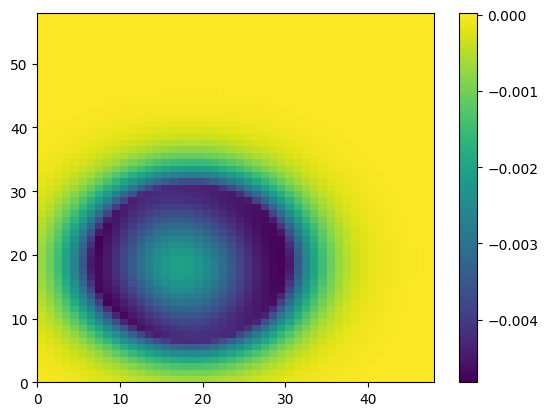

In [ ]:
# The algorithm requires a choice of variance and amplitude for each Gaussian.
# We used a very heuristic method: take the first slice, and assume that it's composed
# of exactly one Gaussian. Given that assumption, we tried a bunch of values for
# variance and amplitude and chose the ones that worked best

variance = 50
amplitude = 6

G = amplitude*dsu.gaussian_mixture(densities[0].shape, variance, [(58,48.2)])
plt.pcolormesh((densities[0]-G)[30:,40:])
plt.colorbar()
plt.show()

# Quantum solution

In [ ]:
best_solutions = []
samplings = []
for k, density in enumerate(densities):
    
    # print some stuff, unimportant
    print(f"Processing density {k+1} of {len(densities)}")
    reg = registers[k]
    pos = positions[k]
    rescaled_pos = rescaled_positions[k]
    n = len(pos)
    print(f"Density {k+1} has {n} qubits")
    # reg.draw()
    # fig, ax = dsu.plot_density(density, rescaled_pos)
    # # plt.show()
    
    # use function to calculate the one-body coefficients of the QUBO
    gamma_list = dsu.gamma_list(density, rescaled_pos, variance)
    
    # roundabout way of finding the scale factor between the QPU units
    # and the density units, it's needed in the next block
    distances_density = dsu.find_possible_distances(rescaled_pos)
    distances_register = dsu.find_possible_distances(pos)
    scale = distances_density[0]/distances_register[0]
    
    # test_gamma_list, test_scale = qubo_solution.calculate_one_body_qubo_coeffs(density, rescaled_pos, variance, pos)
    # print("test coeffs and scale")
    # print(test_gamma_list == gamma_list)
    # print(test_scale == scale)
    # calculate mapping between one-body coefficients of the QUBO
    # and detunings
    dets = np.array([item for item in gamma_list])
    for i in range(n):
        # this line shifts every value by a quantity that is the mean of neighbouring detunings
        # where a neighbour is defined as atoms whithin a blockade radius distance
        dets[i] -= np.mean(dsu.neighbouring_gamma_list(density, rescaled_pos, rescaled_pos[i], scale*brad, variance))
    # the next line line rescales every detuning so that the maximum one
    # turns out to be `max_det` (see first line of this cell)
    dets *= max_det/np.max(np.abs(dets))
    # test_dets =  qubo_solution.scale_detunings(density, pos, rescaled_pos, brad, variance, max_det)

    # print("test dets")
    # print(dets == test_dets)

    # test_seq = qubo_solution.generate_pulse_sequences(MockDevice, reg, dets, max_det, T, omega)
    # Pulser stuff begins --------------------------
    seq = Sequence(reg, MockDevice)
    for i in range(n):
        # add an adiabatic pulse for every qubit
        seq.declare_channel(f'ch{i}', 'rydberg_local')
        seq.target(i, f'ch{i}')
        pulse = Pulse(InterpolatedWaveform(T, [0, omega, 0]), InterpolatedWaveform(T, [-max_det, 0, dets[i]]), 0)
        seq.add(pulse, f'ch{i}')
    # uncomment next line if you want to visualize the pulse sequence
    # # seq.draw()
    # print("test sequences")
    # print(test_seq.to_abstract_repr() == seq.to_abstract_repr())
    

    # # run simulation
    sim = QutipBackend(seq)
    res = sim.run()
    samples = res.sample_final_state(1000)
    # # Pulser stuff ends ----------------------------

    # num_samples = 1000
    # print("test qubo flow")
    # # test_best_solution = qubo_solution.run_qubo(density, executor, MockDevice, reg, rescaled_pos, pos, variance, amplitude, brad, T, omega, max_det)
    # test_best_solution = qubo_solution.run_qubo(density, executor, processor_configs[k], rescaled_pos, pos, variance, amplitude)
    # The next block calculates the cost (from the QUBO) of each
    # bitstring sampled with the analog algorithm 
    quantum_solutions = sorted(samples.items(), key=lambda x: x[1], reverse=True)
    quantum_plus_classical_solutions = []
    for bitstring, count in quantum_solutions:
        # calculate QUBO cost of bitstring
        ising = dsu.ising_energies(rescaled_pos, density, variance, [bitstring], brad, amp=amplitude)
        # the next try-except block is needed because the QUBO cost calculated in the line above
        # resturns empty whenever the blockade constraint is not respected
        try:
            i_bit = ising[0][0]
            i_en = ising[0][1]
            quantum_plus_classical_solutions.append((bitstring, count, i_en)) 
        except IndexError:
            i_bit = bitstring
            i_en = 1e10
            quantum_plus_classical_solutions.append((bitstring, count, i_en)) 
        # print(bitstring, count, i_en)
    # print the best solution, which is defined as the bitstring sampled with the analog algorithm
    # that has the lowest cost in the QUBO
    best_solution = sorted(quantum_plus_classical_solutions, key=lambda x: x[2], reverse=False)[0][0]
    best_solutions.append(best_solution)
    samplings.append(np.array(quantum_plus_classical_solutions, dtype=object))
    print("The best solution is: ", best_solution)
    # print(test_best_solution == best_solution)
    # test_best_solution =  qubo_solution.best_solution_from_samples(samples, rescaled_pos, density, brad, variance, amplitude)
    # print("The best solution according to best_solution_from_samples is:", test_best_solution)
    print()

Processing density 1 of 6
Density 1 has 4 qubits
The best solution is:  1000

Processing density 2 of 6
Density 2 has 9 qubits
The best solution is:  010000010

Processing density 3 of 6
Density 3 has 14 qubits
The best solution is:  00001001000000

Processing density 4 of 6
Density 4 has 14 qubits
The best solution is:  00000010100000

Processing density 5 of 6
Density 5 has 13 qubits
The best solution is:  0000010100000

Processing density 6 of 6
Density 6 has 8 qubits
The best solution is:  00010000



# Remap bitstrings to water molecule positions in the protein cavity

In [ ]:
# for each solution, find index of excited qubits
qubit_indices = []
for bitstring in best_solutions:
    ls = []
    for i,b in enumerate(bitstring):
        if b=='1':
            ls.append(i)
    qubit_indices.append(ls)

In [ ]:
# from their indices, find positions of excited qubits
# (on the scale of the density slices, not in micrometers)
qubit_rescaled_positions = []
for i,indices in enumerate(qubit_indices):
    ls = []
    for idx in indices:
        ls.append(rescaled_positions[i][idx])
    qubit_rescaled_positions.append(ls)

In [ ]:
# from the rescaled positions, find the indices on the 3D map
water_indices = []
for i,res_pos in enumerate(qubit_rescaled_positions):
    ls = []
    for pos in res_pos:
        ls.append((int(pos[1]), int(pos[0])))
    water_indices.append(ls)

In [ ]:
# and finally from the indices find the water molecule positions
# in angstroms
water_positions = []
for i,slice in enumerate(water_indices):
    ls = []
    for idx_i, idx_j in slice:
        ls.append(points[i][idx_i,idx_j])
    water_positions.append(ls)


water_positions

[[array([24.331302  , 16.37638359, 32.70407856])],
 [array([24.331302  , 15.95704731, 32.97639654]),
  array([24.07561299, 16.51974763, 33.842886  ])],
 [array([24.37951925, 15.98075744, 33.93095164]),
  array([25.77148983, 14.29863619, 31.34069132])],
 [array([24.74137793, 14.03285874, 31.84947105]),
  array([24.36242821, 15.3161336 , 33.82555688])],
 [array([24.93911452, 14.45973064, 33.4248458 ]),
  array([24.43747167, 13.73317637, 32.30604137])],
 [array([25.24302078, 13.92074045, 33.51291144])]]

In [ ]:
[t - w for t, w in zip (test_water_postions, water_positions)]

[array([[0., 0., 0.]]),
 array([[ 0.03112621,  0.19775886,  0.30452437],
        [ 0.28681522, -0.36494147, -0.56196508]]),
 array([[ 0.        ,  0.        ,  0.        ],
        [-1.39197058,  1.68212124,  2.59026032]]),
 array([[ 1.0301119 ,  0.26577746, -0.50877973],
        [ 1.40906162, -1.01749741, -2.48486557]]),
 array([[-0.19773659, -0.4268719 , -1.57537476],
        [ 0.30390626,  0.29968237, -0.45657033]]),
 array([[-1.16740778,  1.76033463,  0.87461053]])]